In [1]:
import os
import sys
sys.path.append('utils')

from tqdm import tqdm, trange
import pandas as pd
import numpy as np
from pandas.tseries.offsets import Day, Minute, Hour
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import torch
import torch.nn as nn
import math
import types
from dataset.spot import DailyDataset_nn, get_loader, TOTAL_STD, TOTAL_MEAN, SPOT
from utils.tool import picp, mpiw, rpiw, cwc
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline

In [2]:
dataset = DailyDataset_nn(N=2000, W=14)

Data build range: [window(2010-06-27 00:00:00) - 2010-07-11 00:00:00, 2015-12-31 00:00:00]


In [81]:
trainX, trainY = dataset.get_io(start_date='2012-01-01', end_date='2015-12-31')
testX, testY = dataset.get_io(start_date='2016-01-01', end_date='2016-06-30')

trainX = trainX.numpy()#*TOTAL_STD+TOTAL_MEAN
trainY = trainY.numpy()#*TOTAL_STD+TOTAL_MEAN
testX = testX.numpy()#*TOTAL_STD+TOTAL_MEAN
testY = testY.numpy()#*TOTAL_STD+TOTAL_MEAN

In [113]:
train_x = []
for i in range(trainY.shape[0]):
    train_x += [trainX[i:i+14].reshape(-1)]
train_x = np.array(train_x) 

test_x = []
for i in range(testY.shape[0]):
    test_x += [testX[i:i+14].reshape(-1)]
test_x = np.array(test_x)

train_ys = []
test_ys = []
for i in range(24):
    train_ys += [trainY[:, i]]
train_ys = np.array(train_ys)

In [114]:
target = SPOT["2016":"2016-06-30"].values

In [156]:
test_out = []
test_std = []
for i in trange(24):
#     print("step", str(i+1))
    gpr = GaussianProcessRegressor(kernel=RBF(), alpha=0.001)
    gpr.fit(train_x, train_ys[i])
    mean, std = gpr.predict(test_x,return_std=True)
    test_out += [mean]
    test_std += [std]

  4%|▍         | 1/24 [00:09<03:30,  9.14s/it]/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00032158]), 'nit': 6, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2, 'funcalls': 72}
  ConvergenceWarning)
 92%|█████████▏| 22/24 [03:24<00:16,  8.37s/it]/home/xurenchao/install/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00483208]), 'nit': 3, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2, 'funcalls': 51}
  ConvergenceWarning)
100%|██████████| 24/24 [03:56<00:00, 12.05s/it]


In [157]:
test_out = np.array(test_out).reshape(-1, order='F')*TOTAL_STD+TOTAL_MEAN
test_std = np.array(test_std).reshape(-1, order='F')*TOTAL_STD

In [158]:
test_out

array([23.18928508, 18.6327467 , 14.43739892, ..., 32.63024264,
       29.41560323, 25.00626921])

In [159]:
test_std

array([2.65633032, 4.46767154, 6.07216355, ..., 3.05097466, 3.28513666,
       3.56864336])

In [160]:
lower_bound = test_out - 1.96 * test_std
upper_bound = test_out + 1.96 * test_std

In [161]:
picp(target, lower_bound, upper_bound)

0.9281135531135531

In [162]:
mpiw(target, lower_bound, upper_bound), mpiw(target, lower_bound, upper_bound, 1)

(21.546368835456963, 0.15574937715380197)

In [163]:
rpiw(target, lower_bound, upper_bound), rpiw(target, lower_bound, upper_bound, 1)

(22.847331520803753, 0.165153473476968)

In [164]:
cwc(target, lower_bound, upper_bound), cwc(target, lower_bound, upper_bound, alpha=0.01)

(0.6209973335230254, 3.5934926266788394)

In [165]:
# save bounds
bounds = np.stack((lower_bound, upper_bound))
np.save('./bounds/gpr_95.npy', bounds)

In [166]:
lower_bound = test_out - 2.81 * test_std
upper_bound = test_out + 2.81 * test_std

In [167]:
picp(target, lower_bound, upper_bound)

0.986492673992674

In [168]:
mpiw(target, lower_bound, upper_bound), mpiw(target, lower_bound, upper_bound, 1)

(30.89045736103779, 0.22329374989907322)

In [169]:
rpiw(target, lower_bound, upper_bound), rpiw(target, lower_bound, upper_bound, 1)

(32.755613047682935, 0.23677615330116333)

In [170]:
cwc(target, lower_bound, upper_bound), cwc(target, lower_bound, upper_bound, alpha=0.01)

(0.22329374989907322, 0.4893890376112737)

In [171]:
# save bounds
bounds = np.stack((lower_bound, upper_bound))
np.save('./bounds/gpr_99.npy', bounds)

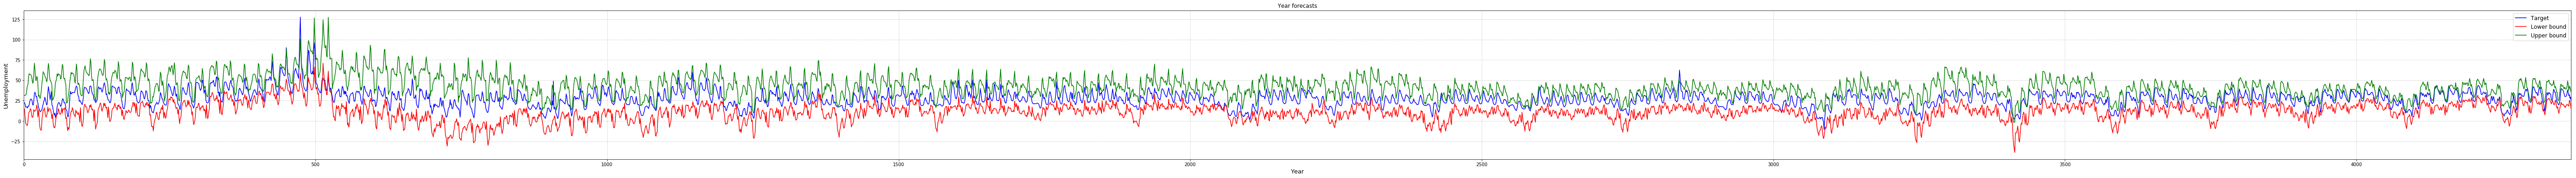

In [150]:
x=np.linspace(1, 182*24, 182*24)
plt.figure(figsize=(100,6))
plt.plot(x, target, color='blue', label='Target')
plt.plot(x, lower_bound, color='red', label='Lower bound')
plt.plot(x, upper_bound, color='green', label='Upper bound')

plt.xlim(0,182*24)
plt.legend(fontsize='large') # 显示图例

plt.title('Year forecasts')
plt.xlabel('Year',fontsize=13)
plt.ylabel('Unemployment',fontsize=13)

plt.grid(linestyle=':', linewidth=1)
plt.show()